In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys 
sys.path.append("./l1tf")
import pandas_wrapper

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset

from FeatureEngineering import FeatureEngineering

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

data_folder = './data/'

In [2]:
train = pd.read_csv(data_folder + 'NASDAQ_m_l1tf0.005_wFE_train.csv')
test = pd.read_csv(data_folder + 'NASDAQ_m_l1tf0.005_wFE_test.csv')

In [3]:
train['close'] = train['close'].shift(-10)
test['close'] = test['close'].shift(-10)
train.dropna(inplace=True)
test.dropna(inplace=True)

In [4]:
num_points_for_train = 1950*4*5 # see 64 window and predict after 30m
offset = 10
target_col = train.columns.get_loc("close") # target column index
batch_size = 1
num_workers = 4
pin_memory = True
device = 'cuda'
num_epoch = 100
lr = 1e-4

In [5]:
#simple FCN regression model
class DNN(nn.Module):
    def __init__(self, in_features, hidden_dim, out_features):
        super().__init__()        
        self.fc1 = nn.Linear(in_features, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2) 
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc5 = nn.Linear(hidden_dim*2, hidden_dim) 
        self.out = nn.Linear(hidden_dim, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.out(x)
        return x

In [6]:
model = DNN(in_features= 15,
            hidden_dim = 64,
            out_features=1).to(device) 
optim = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [7]:
x = torch.tensor(train.iloc[0: len(train)-1, 1:].values.astype(np.float64)).to('cuda').float()
y = torch.tensor(train.iloc[0: len(train)-1, 0].values.astype(np.float64)).to('cuda').float()

num_epoch = 200
model = model.train()
for epoch in tqdm(range(0, num_epoch)):
    outputs = model(x)
    loss = criterion(outputs, y)
                
    optim.zero_grad()
    loss.backward()
    optim.step()

    print(f"{epoch} loss: {loss}")

  0%|          | 0/200 [00:00<?, ?it/s]

0 loss: 64817536.0
1 loss: 62479848.0
2 loss: 60180416.0
3 loss: 57914780.0
4 loss: 55678816.0
5 loss: 53467308.0
6 loss: 51274512.0
7 loss: 49094920.0
8 loss: 46923540.0
9 loss: 44756028.0
10 loss: 42588728.0
11 loss: 40418660.0
12 loss: 38243544.0
13 loss: 36061908.0
14 loss: 33873184.0
15 loss: 31677864.0
16 loss: 29477622.0
17 loss: 27275470.0
18 loss: 25075856.0
19 loss: 22884804.0
20 loss: 20710004.0
21 loss: 18560930.0
22 loss: 16448937.0
23 loss: 14387308.0
24 loss: 12391298.0
25 loss: 10478076.0
26 loss: 8666568.0
27 loss: 6977160.5
28 loss: 5431198.5
29 loss: 4050205.25
30 loss: 2854784.25
31 loss: 1863113.125
32 loss: 1089020.5
33 loss: 539684.125
34 loss: 213107.671875
35 loss: 95763.1953125
36 loss: 161016.984375
37 loss: 369157.34375
38 loss: 669807.0
39 loss: 1007025.875
40 loss: 1326440.5
41 loss: 1582730.25
42 loss: 1745397.875
43 loss: 1801327.875
44 loss: 1753862.625
45 loss: 1619216.125
46 loss: 1421569.125
47 loss: 1188104.875
48 loss: 944849.625
49 loss: 713753.68

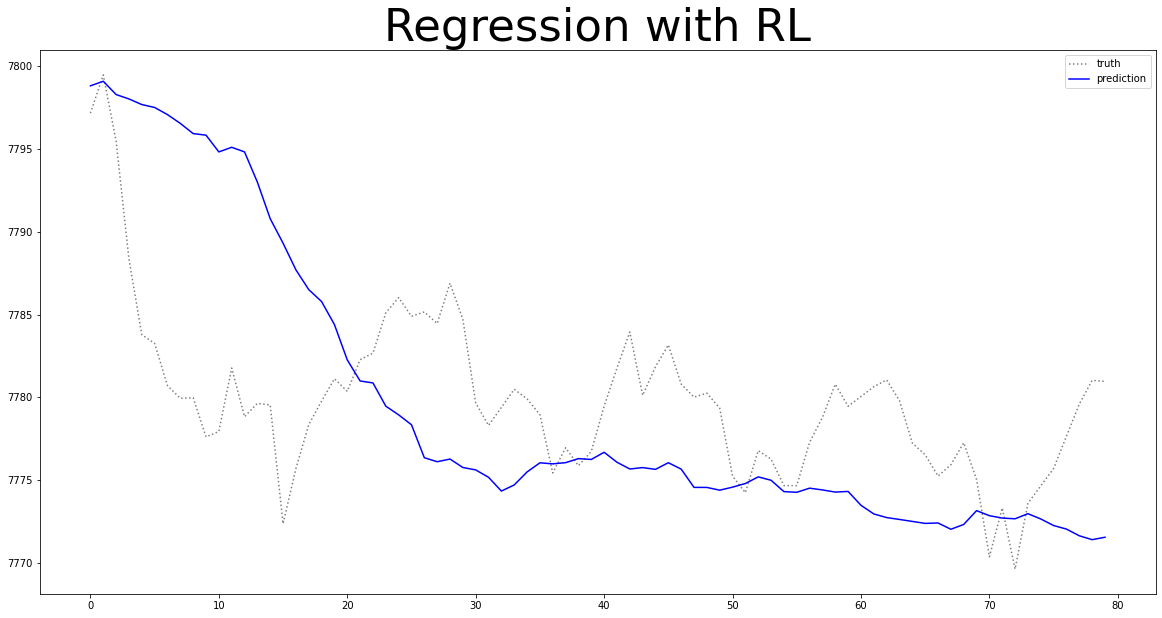

MSE:  50534.1484375
rMSE:  224.7980194091797
MAE:  173.64175415039062
MAPE:  0.022366786375641823


In [8]:
x = torch.tensor(train.iloc[0:len(test)-1, 1:].values.astype(np.float64)).to('cuda').float()
y = torch.tensor(train.iloc[0: len(test)-1, 0].values.astype(np.float64)).to('cuda').float()
with torch.no_grad():
    model = model.eval()
    test_loss1 = 0
    test_loss2 = 0
    test_loss3 = 0
    test_loss4 = 0

    outputs = model(x)
    loss = criterion(outputs, y)

    criterion3 = nn.L1Loss()
    loss3 = criterion3(input=outputs, target = y)

    loss4 = torch.mean(torch.abs(torch.subtract(outputs, y) / y))

    test_loss1=loss.item()
    test_loss2=torch.sqrt(loss).item()
    test_loss3=loss3.item()
    test_loss4=loss4.item()
                    
    plt.figure(figsize=[20,10])
    plt.plot(y.detach().to('cpu').numpy()[0:80], linestyle=':', color = 'black', alpha = 0.5, label = 'truth')
    plt.plot(outputs.detach().to('cpu').numpy()[0:80], color = 'blue', label = 'prediction')
    plt.legend()
    plt.title("Regression with RL", fontsize=45)
    plt.show()
                
    final_loss = test_loss2

    print("MSE: ", test_loss1)
    print("rMSE: ", test_loss2)
    print("MAE: ", test_loss3)
    print("MAPE: ", test_loss4)

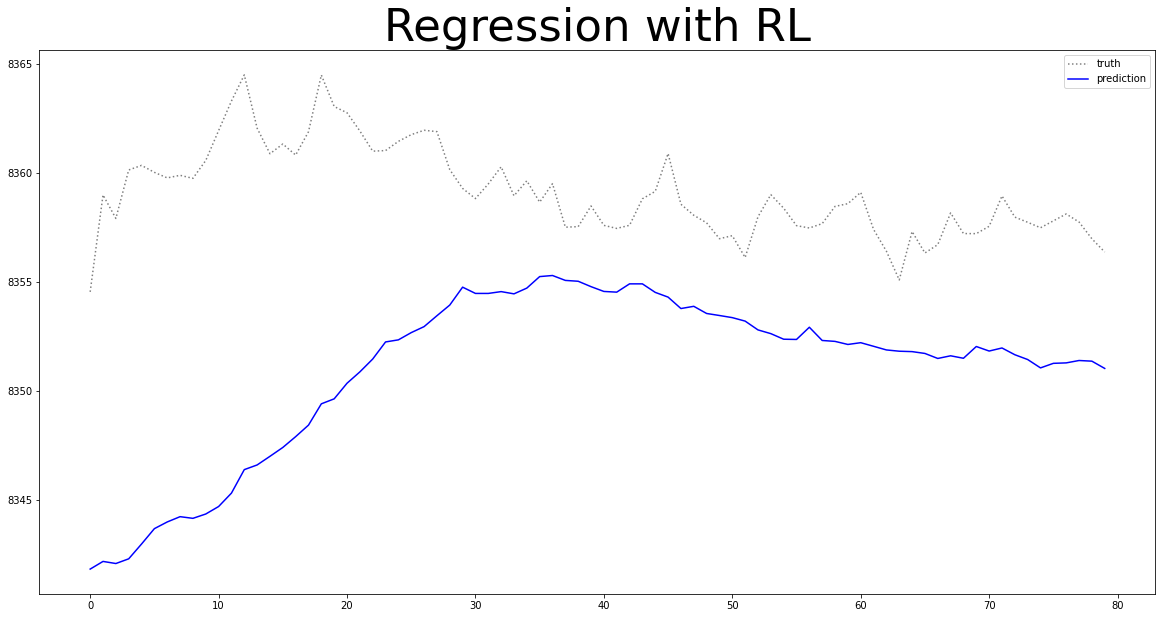

MSE:  95420.7265625
rMSE:  308.9024658203125
MAE:  250.21229553222656
MAPE:  0.029105136170983315


In [9]:
x = torch.tensor(test.iloc[0:len(test)-1, 1:].values.astype(np.float64)).to('cuda').float()
y = torch.tensor(test.iloc[0: len(test)-1, 0].values.astype(np.float64)).to('cuda').float()
with torch.no_grad():
    model = model.eval()
    test_loss1 = 0
    test_loss2 = 0
    test_loss3 = 0
    test_loss4 = 0

    outputs = model(x)
    loss = criterion(outputs, y)

    criterion3 = nn.L1Loss()
    loss3 = criterion3(input=outputs, target = y)

    loss4 = torch.mean(torch.abs(torch.subtract(outputs, y) / y))

    test_loss1=loss.item()
    test_loss2=torch.sqrt(loss).item()
    test_loss3=loss3.item()
    test_loss4=loss4.item()
                    
    plt.figure(figsize=[20,10])
    plt.plot(y.detach().to('cpu').numpy()[0:80], linestyle=':', color = 'black', alpha = 0.5, label = 'truth')
    plt.plot(outputs.detach().to('cpu').numpy()[0:80], color = 'blue', label = 'prediction')
    plt.legend()
    plt.title("Regression with RL", fontsize=45)
    plt.show()
                
    final_loss = test_loss2

    print("MSE: ", test_loss1)
    print("rMSE: ", test_loss2)
    print("MAE: ", test_loss3)
    print("MAPE: ", test_loss4)

In [10]:
torch.save({
    'epoch': 100,
    'model_state_dict' : model.state_dict(),
    'optimizer_state_dict' : optim.state_dict(),
    'loss' : criterion
}, './checkpoint-reg-baseline/fc.pt')